# Household Vehicle Ownership – New Jersey
New Jersey is the densest state in the US, and counties like Hudson include some of the highest rates of public transit use.

Below are some stats about household car ownership in NJ.

In [1]:
from utz import *
from hhvs.plot_utils import *
from hhvs import plot_utils
ire.chdir('../nj')

In [2]:
subtitle = 'NJ counties, 2021'
plot_kwargs = dict(subtitle=subtitle)
abs_plot = partial(plot_utils.abs_plot, **plot_kwargs)
pct_plot = partial(plot_utils.pct_plot, **plot_kwargs)

In [3]:
url = 'https://api.census.gov/data/2021/acs/acs1?get=NAME,B08201_002E,B08201_003E,B08201_004E,B08201_005E,B08201_006E&for=county:*&in=state:34'
# d = pd.read_json(url)
d = pd.read_json('vehicles2021.json')
d

0            1            2            3  \
0                            NAME  B08201_002E  B08201_003E  B08201_004E   
1   Burlington County, New Jersey         8096        56805        68949   
2   Cumberland County, New Jersey         5053        16540        18524   
3       Hudson County, New Jersey        97657       130644        48242   
4    Middlesex County, New Jersey        23291       104574       122144   
5        Ocean County, New Jersey        14427        83106        94384   
6        Salem County, New Jersey         2715         6556         9633   
7        Union County, New Jersey        23055        71583        73878   
8     Atlantic County, New Jersey        15924        39974        37560   
9       Bergen County, New Jersey        28456       121851       135117   
10      Camden County, New Jersey        20311        70247        75506   
11    Cape May County, New Jersey         1322        18241        21570   
12       Essex County, New Jersey        68739       133084        88384   
13  Gloucester County, New Jersey         5782        31894        45453   
14   Hunterdon County, New Jersey         1592        13056        19489   
15      Mercer County, New Jersey        16161        49912        50258   
16    Monmouth County, New Jersey        14932        80387        97181   
17      Morris County, New Jersey         9031        57117        79365   
18     Passaic County, New Jersey        23600        65008        57497   
19    Somerset County, New Jersey         6731        40046        52501   
20      Sussex County, New Jersey         2389        14267        25160   
21      Warren County, New Jersey         3038        13508        17786   

              4            5      6       7  
0   B08201_005E  B08201_006E  state  county  
1         28093        13916     34     005  
2         10451         3315     34     011  
3         11909         3548     34     017  
4         38014        19808     34     023  
5         33775        15044     34     029  
6          3949         2120     34     033  
7         24057         8819     34     039  
8         13979         4862     34     001  
9         45014        21592     34     003  
10        24154        10940     34     007  
11         5182         2545     34     009  
12        23411         8835     34     013  
13        18686        10687     34     015  
14        10802         6353     34     019  
15        20635         7004     34     021  
16        38258        19980     34     025  
17        31166        16168     34     027  
18        21190         9768     34     031  
19        22378         9283     34     035  
20        10858         6093     34     037  
21         7875         4146     34     041

## Households x Vehicles x County

Source: [api.census.gov].

[api.census.gov]: https://api.census.gov/data/2021/acs/acs1?get=NAME,B08201_002E,B08201_003E,B08201_004E,B08201_005E,B08201_006E&for=county:*&in=state:34

### Households

In [4]:
hhs = d.copy()
hhs.columns = hhs.iloc[0]
hhs = hhs.iloc[1:]
hhs = (
    sxs(
        hhs.NAME.str.extract(r'(?P<County>.*) County, New Jersey'),
        hhs,
    )
    .set_index('County')
    .drop(columns=['NAME', 'state'])
)
hhs = hhs.rename(columns={
    'B08201_002E': '0 vehicles',
    'B08201_003E': '1 vehicle',
    'B08201_004E': '2 vehicles',
    'B08201_005E': '3 vehicles',
    'B08201_006E': '4+ vehicles',
    'county': 'ccode',
})
hhs.columns.name = 'Household vehicles'
ccode = hhs.ccode
hhs = (
    hhs
    .drop(columns='ccode')
    .astype(int)
)
hhs_totals = hhs.sum(1).rename('Total households')
hhst = sxs(hhs, hhs_totals).sort_values('Total households', ascending=False)
hhs = hhst.drop(columns='Total households')
hhs.columns = hhs.columns.copy()
hhs.columns.name = 'Household vehicles'
export(hhst, 'hh', per_page=50)

Saved parquet to ../nj/.ire/hh.parquet


### Percentages

In [5]:
hhs_pcts = hhs.div(hhs_totals, axis=0).sort_values('0 vehicles', ascending=False)
hhsp_exp = hhs_pcts.copy()
hhs_pcts.columns = ['0', '1', '2', '3', '4+']
hhs_pcts.columns.name = 'Household vehicles'
export(hhsp_exp, 'hh_pct', per_page=50, fmts={ float: '.1%' })

Saved parquet to ../nj/.ire/hh_pct.parquet


## 

### Households

Saved plotly to ../nj/.ire/households_by_vehicle_count.json


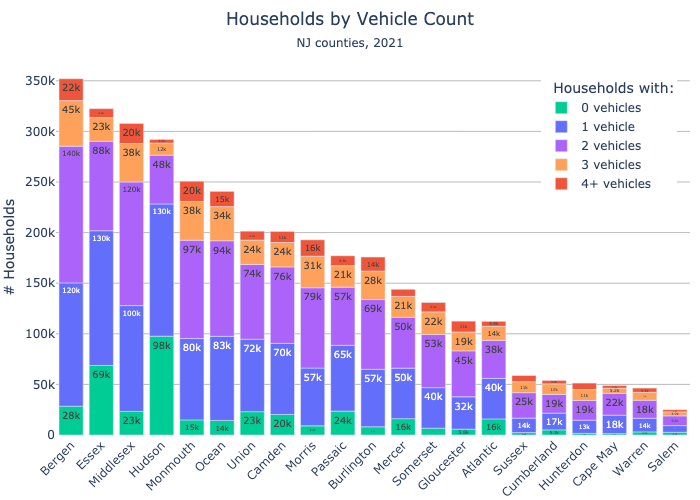

In [6]:
abs_plot(
    hhs,
    melt='# Households',
    title='Households by Vehicle Count',
    legend=ur_legend('  Households with:'),
    name='households_by_vehicle_count',
)

### Percentages

Saved plotly to ../nj/.ire/households_by_vehicle_count_pcts.json


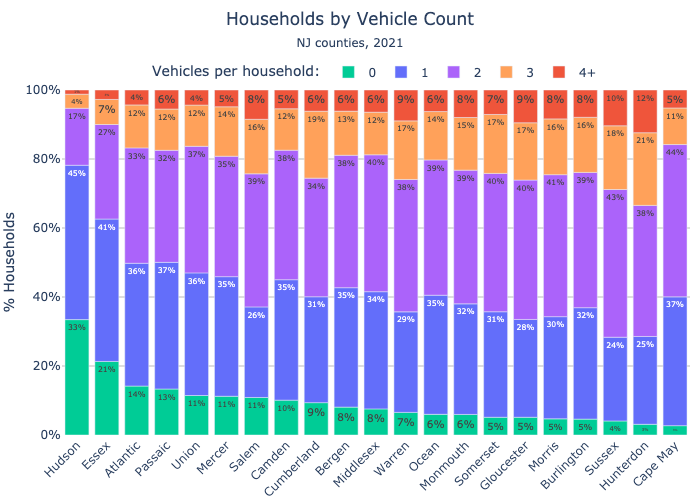

In [7]:
pct_plot(
    hhs_pcts,
    melt='% Households',
    title='Households by Vehicle Count',
    name='households_by_vehicle_count_pcts',
)

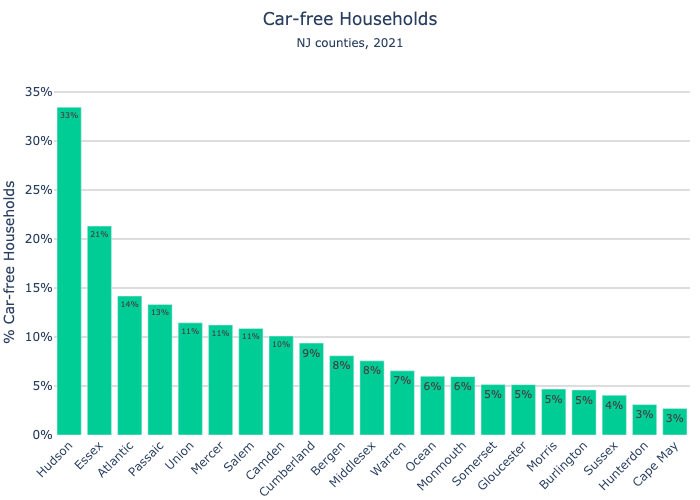

In [8]:
plot(
    hhs_pcts[['0']],
    melt='% Car-free Households',
    title='Car-free Households',
    subtitle=subtitle,
    pct=True,
    yrange=None,
    layout=dict(**pct_layout, showlegend=False),
    name='car_free_households',
    export=False,
)

In [9]:
columns = {
    '1 vehicle': '1-vehicle households',
    '2 vehicles': '2-vehicle households',
    '3 vehicles': '3-vehicle households',
    '4+ vehicles': '4+-vehicle households',
}
vhs = hhs.copy().rename(columns=columns)[columns.values()]
for i in range(1, 5):
    s = '4+' if i == 4 else f'{i}'
    col = f'{s}-vehicle households'
    vhs[col] *= i
vhs_totals = vhs.sum(1).rename('Total vehicles')
vhst = sxs(vhs, vhs_totals).sort_values('Total vehicles', ascending=False)
vhs = vhst.drop(columns='Total vehicles')
vhs.columns = vhs.columns.copy()
vhs.columns.name = 'Household vehicles'
vhs

Household vehicles  1-vehicle households  2-vehicle households  \
County                                                           
Bergen                            121851                270234   
Middlesex                         104574                244288   
Monmouth                           80387                194362   
Ocean                              83106                188768   
Essex                             133084                176768   
Morris                             57117                158730   
Camden                             70247                151012   
Burlington                         56805                137898   
Union                              71583                147756   
Passaic                            65008                114994   
Hudson                            130644                 96484   
Somerset                           40046                105002   
Mercer                             49912                100516   
Gloucester                         31894                 90906   
Atlantic                           39974                 75120   
Sussex                             14267                 50320   
Hunterdon                          13056                 38978   
Cumberland                         16540                 37048   
Warren                             13508                 35572   
Cape May                           18241                 43140   
Salem                               6556                 19266   

Household vehicles  3-vehicle households  4+-vehicle households  
County                                                           
Bergen                            135042                  86368  
Middlesex                         114042                  79232  
Monmouth                          114774                  79920  
Ocean                             101325                  60176  
Essex                              70233                  35340  
Morris                             93498                  64672  
Camden                             72462                  43760  
Burlington                         84279                  55664  
Union                              72171                  35276  
Passaic                            63570                  39072  
Hudson                             35727                  14192  
Somerset                           67134                  37132  
Mercer                             61905                  28016  
Gloucester                         56058                  42748  
Atlantic                           41937                  19448  
Sussex                             32574                  24372  
Hunterdon                          32406                  25412  
Cumberland                         31353                  13260  
Warren                             23625                  16584  
Cape May                           15546                  10180  
Salem                              11847                   8480

## 

### Households

Saved plotly to ../nj/.ire/vehicles_by_household_count.json


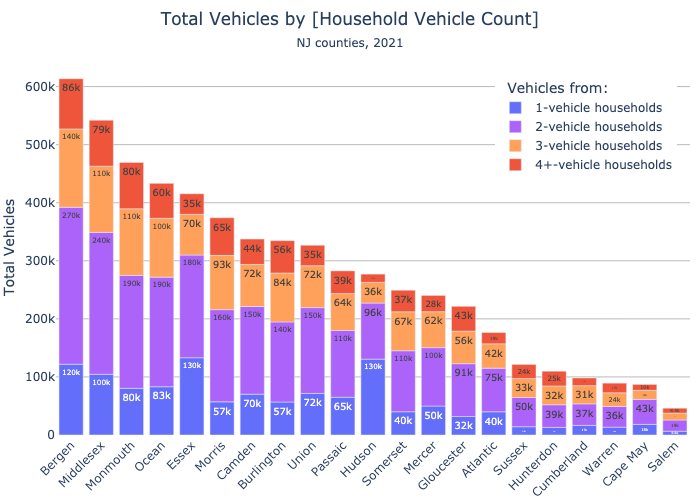

In [10]:
abs_plot(
    vhs,
    melt='Total Vehicles',
    title='Total Vehicles by [Household Vehicle Count]',
    colors=colors[1:],
    layout=abs_layout,
    legend=ur_legend('  Vehicles from:'),
    name='vehicles_by_household_count',
)

In [11]:
vhs_pcts = vhs.div(vhs_totals, axis=0).sort_values('1-vehicle households', ascending=False)
vhs_pcts.columns = ['1', '2', '3', '4+']
vhs_pcts.columns.name = 'Household vehicles'
vhs_pcts

Household vehicles         1         2         3        4+
County                                                    
Hudson              0.471559  0.348259  0.128956  0.051226
Essex               0.320356  0.425511  0.169063  0.085070
Passaic             0.230000  0.406851  0.224912  0.138238
Atlantic            0.226509  0.425660  0.237632  0.110200
Union               0.219052  0.452149  0.220851  0.107948
Cape May            0.209409  0.495253  0.178470  0.116868
Camden              0.208151  0.447468  0.214714  0.129667
Mercer              0.207665  0.418209  0.257563  0.116564
Bergen              0.198618  0.440483  0.220119  0.140780
Middlesex           0.192893  0.450603  0.210357  0.146148
Ocean               0.191765  0.435577  0.233804  0.138854
Monmouth            0.171239  0.414027  0.244490  0.170244
Burlington          0.169747  0.412071  0.251845  0.166337
Cumberland          0.168430  0.377267  0.319274  0.135029
Somerset            0.160625  0.421164  0.269275  0.148937
Morris              0.152712  0.424392  0.249983  0.172912
Warren              0.151284  0.398392  0.264590  0.185734
Gloucester          0.143922  0.410215  0.252962  0.192901
Salem               0.142062  0.417474  0.256712  0.183753
Hunterdon           0.118851  0.354823  0.294997  0.231329
Sussex              0.117392  0.414044  0.268026  0.200538

### Percentages

Saved plotly to ../nj/.ire/vehicles_by_household_count_pcts.json


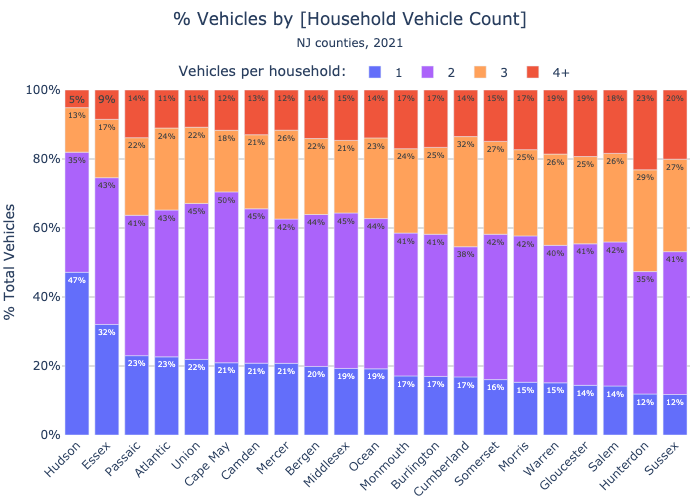

In [12]:
pct_plot(
    vhs_pcts,
    melt='% Total Vehicles',
    title='% Vehicles by [Household Vehicle Count]',
    colors=colors[1:],
    name='vehicles_by_household_count_pcts',
)